In [1]:
import numpy as np
from IPython.display import FileLinks
from IPython.display import IFrame, display
from IPython import display
import os
np.set_printoptions(linewidth=100)
import sympy as sm
import sympy.abc as sbl
from scipy.sparse import diags
import scipy.sparse.linalg as la
import scipy.sparse as sp
sm.init_printing()
import time
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
import matplotlib

# Hyperparameters

In [2]:
N = 4
h = 1 /N

# Domain

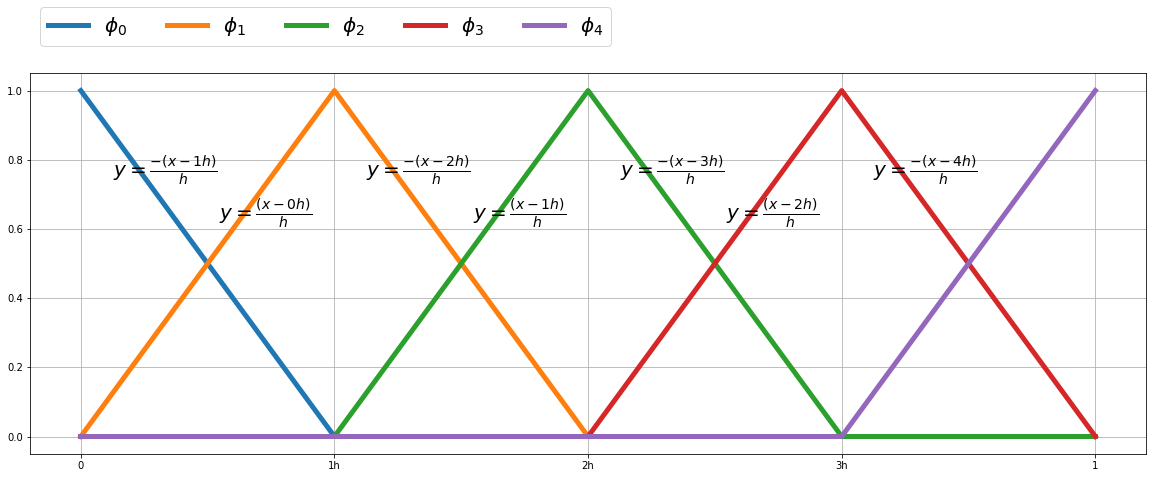

In [3]:
l = []

for i in range(N + 1):
    arr = np.array([0]* (N + 1))
    arr[i] = 1
    l.extend([np.linspace(0, 1, N+1), arr])
plt.figure(figsize=(20, 7))

plt.plot(*l, linewidth = 5)
plt.grid()
leg = plt.legend([r"$\phi_{}$".format(i) for i in range(N+1)],loc = 2, prop={'size': 20}, ncol=8,  bbox_to_anchor=(0, 1.2 ),   )

for i in range(N + 1):
    if i!=N :
        ann = plt.annotate(r'$ y = \frac {{-(x-{}h)}}{{h}}$'.format(i+1), xy =(i*h+h/4, 1-h), xytext=(i*h+h/8, 1-h), weight='bold', fontsize=10)
        ann.set_fontsize(20)
    if i!=0:
        ann = plt.annotate(r'$ y = \frac {{(x-{}h)}}{{h}}$'.format(i-1), xy = (i*h+h/4, 1-h), xytext=(i*h-h/2.2, 1-h-h/2))
        ann.set_fontsize(20)
        
x_ticks = plt.xticks(np.linspace(0, 1, N+1) , ["0"]+[f"{i}h" for i in range(1, N)]+[str(1)])
plt.savefig("1.png")

In [4]:
import IPython
IPython.__version__

'7.7.0'

## Equations 

\begin{equation}
\underline {System \ of \ equations :}
\\\ u_t + u  u_x + v_x + \beta u_{xx} = 0 
\\ v_t + (uv)_x - \beta v_{xx} = 0 
\end{equation}

\begin{equation}
\underline { Discontinuous \ Galerkin \ Solution :}
\\ u^h = 
\sum_{i= 0}^{n} a_i(t)  \phi_i(x) 
\end{equation}

\begin{equation}
\underline {System \ of \ equations :}
\\\ \int_0^1 { (w u_t + wu  u_x + wv_x + \beta w u_{xx})} \ dx= 0 
\\ \int_0^1 { (wv_t + w (uv)_x - \beta w v_{xx})} \ dx= 0 
\end{equation}



<h3 align="center" style="color:#FFE647;">Equation  (i) </h3> 
\begin{equation}
\\\ \int_0^1  (w u_t  + wuu_x + wv_x ) \ dx  + \beta \ (w(1) u_x(1) - w(0) u_x(0)) - \beta \int_0^1 {w_x u_x} \ dx= 0 
\\  (A \alpha^{'} + \alpha^TB\alpha +C\gamma)\hspace{5mm} +\hspace{15mm}\beta ( D \alpha \hspace{10mm} - \hspace{10mm}E \alpha) \hspace{10mm} - \beta F  \alpha  = 0 
\\ w = {\phi_j}
\end{equation}

<h3 align="center" style="color:#FF3647;">Equation  (ii) </h3> 

\begin{equation}
\\\ \int_0^1  (w v_t  + w(uv)_x ) \ dx  - \beta \ (w(1) v_x(1) - w(0) v_x(0)) + \beta \int_0^1 {w_x v_x} \ dx= 0 
\\  (A \gamma^{'} + \alpha^TG\gamma)\hspace{5mm} -\hspace{15mm}\beta ( D \gamma \hspace{10mm} - \hspace{10mm}E \gamma) \hspace{10mm} + \beta F  \gamma = 0 
\\ w = {\phi_j}
\end{equation}

In [5]:
x = sbl.x
t = sbl.t

## A

In [6]:

sm.Integral(\
    sm.Matrix(N+1, 1, lambda k, j:(sm.Function(f"phi_{k}")(x),
            sm.Matrix(1, N+1, lambda i,j : sm.Function(f"phi_{j}")(x) if abs(j-k) in [0, 1] else 0),\
                                   sm.Matrix(N+1, 1, lambda i,j : sm.Function(r"\alpha^{{'}}_{}".format(i))(t)))), (x,0,1))

1                                                              
⌠                                                              
⎮ ⎡  ⎛                                ⎡\alpha_0__{'}(t)⎤⎞  ⎤   
⎮ ⎢  ⎜                                ⎢                ⎥⎟  ⎥   
⎮ ⎢  ⎜                                ⎢\alpha_1__{'}(t)⎥⎟  ⎥   
⎮ ⎢  ⎜                                ⎢                ⎥⎟  ⎥   
⎮ ⎢  ⎜φ₀(x), [φ₀(x)  φ₁(x)  0  0  0], ⎢\alpha_2__{'}(t)⎥⎟  ⎥   
⎮ ⎢  ⎜                                ⎢                ⎥⎟  ⎥   
⎮ ⎢  ⎜                                ⎢\alpha_3__{'}(t)⎥⎟  ⎥   
⎮ ⎢  ⎜                                ⎢                ⎥⎟  ⎥   
⎮ ⎢  ⎝                                ⎣\alpha_4__{'}(t)⎦⎠  ⎥   
⎮ ⎢                                                        ⎥   
⎮ ⎢⎛                                    ⎡\alpha_0__{'}(t)⎤⎞⎥   
⎮ ⎢⎜                                    ⎢                ⎥⎟⎥   
⎮ ⎢⎜                                    ⎢\alpha_1__{'}(t)⎥⎟⎥   
⎮ ⎢⎜                                    

## B

In [7]:
sm.Integral(sm.Matrix(N+1, 1, lambda k, i: (
    sm.Matrix(N+1, 1, lambda i,j : sm.Function(f"alpha_{i}")(t)).T,\
       sm.Function(f"phi_{k}")(x)*sm.Matrix(N+1, N+1, lambda i,j : sm.Function(r"\phi^{{'}}_{}".format(j))(x)*
        sm.Function(f"phi_{i}")(x) if abs(i-j) in [0, 1] and abs(i-k) in [0, 1] and abs(k-j) in [0, 1] else 0),
    sm.Matrix(N+1, 1, lambda i,j : sm.Function(f"alpha_{i}")(t))) ), (x, 0, 1))

1                                                                             
⌠                                                                             
⎮ ⎡            ⎛                                     ⎡                   2    
⎮ ⎢            ⎜                                     ⎢  \phi_0__{'}(x)⋅φ₀ (x) 
⎮ ⎢            ⎜                                     ⎢                        
⎮ ⎢            ⎜                                     ⎢\phi_0__{'}(x)⋅φ₀(x)⋅φ₁(
⎮ ⎢            ⎜                                     ⎢                        
⎮ ⎢            ⎜[α₀(t)  α₁(t)  α₂(t)  α₃(t)  α₄(t)], ⎢            0           
⎮ ⎢            ⎜                                     ⎢                        
⎮ ⎢            ⎜                                     ⎢            0           
⎮ ⎢            ⎜                                     ⎢                        
⎮ ⎢            ⎝                                     ⎣            0           
⎮ ⎢                                                 

## C

In [8]:
sm.Integral(\
    sm.Matrix(N+1, 1, lambda k, j:(sm.Function(f"phi_{k}")(x),
            sm.Matrix(1, N+1, lambda i,j : sm.Function(f"\phi_{j}^{{'}}")(x) if abs(j-k) in [0, 1] else 0),\
                                   sm.Matrix(N+1, 1, lambda i,j : sm.Function(r"gamma_{}".format(i))(t)))), (x, 0, 1))

1                                                                             
⌠                                                                             
⎮ ⎡      ⎛                                                  ⎡γ₀(t)⎤⎞       ⎤  
⎮ ⎢      ⎜                                                  ⎢     ⎥⎟       ⎥  
⎮ ⎢      ⎜                                                  ⎢γ₁(t)⎥⎟       ⎥  
⎮ ⎢      ⎜                                                  ⎢     ⎥⎟       ⎥  
⎮ ⎢      ⎜φ₀(x), [\phi_0__{'}(x)  \phi_1__{'}(x)  0  0  0], ⎢γ₂(t)⎥⎟       ⎥  
⎮ ⎢      ⎜                                                  ⎢     ⎥⎟       ⎥  
⎮ ⎢      ⎜                                                  ⎢γ₃(t)⎥⎟       ⎥  
⎮ ⎢      ⎜                                                  ⎢     ⎥⎟       ⎥  
⎮ ⎢      ⎝                                                  ⎣γ₄(t)⎦⎠       ⎥  
⎮ ⎢                                                                        ⎥  
⎮ ⎢⎛                                                

# D

In [9]:
sm.Matrix(N+1, 1, lambda k, _:(sm.Function(f"phi_{k}")(1),\
            sm.Matrix(1, N+1, lambda i,j : sm.Function(f"\phi_{j}^{{'}}")(1) if abs(j-k) in [0, 1] and k==N else 0),\
                                   sm.Matrix(N+1, 1, lambda i,j : sm.Function(r"alpha_{}".format(i))(t))))

⎡             ⎛                        ⎡α₀(t)⎤⎞             ⎤
⎢             ⎜                        ⎢     ⎥⎟             ⎥
⎢             ⎜                        ⎢α₁(t)⎥⎟             ⎥
⎢             ⎜                        ⎢     ⎥⎟             ⎥
⎢             ⎜φ₀(1), [0  0  0  0  0], ⎢α₂(t)⎥⎟             ⎥
⎢             ⎜                        ⎢     ⎥⎟             ⎥
⎢             ⎜                        ⎢α₃(t)⎥⎟             ⎥
⎢             ⎜                        ⎢     ⎥⎟             ⎥
⎢             ⎝                        ⎣α₄(t)⎦⎠             ⎥
⎢                                                           ⎥
⎢             ⎛                        ⎡α₀(t)⎤⎞             ⎥
⎢             ⎜                        ⎢     ⎥⎟             ⎥
⎢             ⎜                        ⎢α₁(t)⎥⎟             ⎥
⎢             ⎜                        ⎢     ⎥⎟             ⎥
⎢             ⎜φ₁(1), [0  0  0  0  0], ⎢α₂(t)⎥⎟             ⎥
⎢             ⎜                        ⎢     ⎥⎟             ⎥
⎢       

# E

In [10]:
sm.Matrix(N+1, 1, lambda k, j:(sm.Function(f"phi_{k}")(0),
            sm.Matrix(1, N+1, lambda i,j : sm.Function(f"\phi_{j}^{{'}}")(0) if abs(j-k) in [0, 1] and k==0 else 0),\
                                   sm.Matrix(N+1, 1, lambda i,j : sm.Function(r"alpha_{}".format(i))(t))))

⎡⎛                                                  ⎡α₀(t)⎤⎞⎤
⎢⎜                                                  ⎢     ⎥⎟⎥
⎢⎜                                                  ⎢α₁(t)⎥⎟⎥
⎢⎜                                                  ⎢     ⎥⎟⎥
⎢⎜φ₀(0), [\phi_0__{'}(0)  \phi_1__{'}(0)  0  0  0], ⎢α₂(t)⎥⎟⎥
⎢⎜                                                  ⎢     ⎥⎟⎥
⎢⎜                                                  ⎢α₃(t)⎥⎟⎥
⎢⎜                                                  ⎢     ⎥⎟⎥
⎢⎝                                                  ⎣α₄(t)⎦⎠⎥
⎢                                                           ⎥
⎢             ⎛                        ⎡α₀(t)⎤⎞             ⎥
⎢             ⎜                        ⎢     ⎥⎟             ⎥
⎢             ⎜                        ⎢α₁(t)⎥⎟             ⎥
⎢             ⎜                        ⎢     ⎥⎟             ⎥
⎢             ⎜φ₁(0), [0  0  0  0  0], ⎢α₂(t)⎥⎟             ⎥
⎢             ⎜                        ⎢     ⎥⎟             ⎥
⎢       

# F

In [11]:
sm.Integral(\
    sm.Matrix(N+1, 1, lambda k, j:(sm.Function(f"\phi_{k}^{{'}}")(x),
            sm.Matrix(1, N+1, lambda i,j : sm.Function(f"\phi_{j}^{{'}}")(x) if abs(j-k) in [0, 1] else 0),\
                                   sm.Matrix(N+1, 1, lambda i,j : sm.Function(r"alpha_{}".format(i))(t)))), (x, 0, 1))

1                                                                             
⌠                                                                             
⎮ ⎡      ⎛                                                           ⎡α₀(t)⎤⎞ 
⎮ ⎢      ⎜                                                           ⎢     ⎥⎟ 
⎮ ⎢      ⎜                                                           ⎢α₁(t)⎥⎟ 
⎮ ⎢      ⎜                                                           ⎢     ⎥⎟ 
⎮ ⎢      ⎜\phi_0__{'}(x), [\phi_0__{'}(x)  \phi_1__{'}(x)  0  0  0], ⎢α₂(t)⎥⎟ 
⎮ ⎢      ⎜                                                           ⎢     ⎥⎟ 
⎮ ⎢      ⎜                                                           ⎢α₃(t)⎥⎟ 
⎮ ⎢      ⎜                                                           ⎢     ⎥⎟ 
⎮ ⎢      ⎝                                                           ⎣α₄(t)⎦⎠ 
⎮ ⎢                                                                           
⎮ ⎢⎛                                                

# G

\begin{equation}
 (uv)_x = u \ v_x + v \ u_x  = 2 u v_x \ or  \ 2 v u_x
\end{equation}

In [12]:
2 *sm.Integral(sm.Matrix(N+1, 1, lambda k, i: (
    sm.Matrix(N+1, 1, lambda i,j : sm.Function(f"gamma_{i}")(t)).T,\
       sm.Function(f"phi_{k}")(x)*sm.Matrix(N+1, N+1, lambda i,j : sm.Function(r"\phi^{{'}}_{}".format(j))(x)*
        sm.Function(f"phi_{i}")(x) if abs(i-j) in [0, 1] and abs(i-k) in [0, 1] and abs(k-j) in [0, 1] else 0),
    sm.Matrix(N+1, 1, lambda i,j : sm.Function(f"alpha_{i}")(t))) ), (x, 0, 1))

  1                                                                           
  ⌠                                                                           
  ⎮ ⎡            ⎛                                     ⎡                   2  
  ⎮ ⎢            ⎜                                     ⎢  \phi_0__{'}(x)⋅φ₀ (x
  ⎮ ⎢            ⎜                                     ⎢                      
  ⎮ ⎢            ⎜                                     ⎢\phi_0__{'}(x)⋅φ₀(x)⋅φ
  ⎮ ⎢            ⎜                                     ⎢                      
  ⎮ ⎢            ⎜[γ₀(t)  γ₁(t)  γ₂(t)  γ₃(t)  γ₄(t)], ⎢            0         
  ⎮ ⎢            ⎜                                     ⎢                      
  ⎮ ⎢            ⎜                                     ⎢            0         
  ⎮ ⎢            ⎜                                     ⎢                      
  ⎮ ⎢            ⎝                                     ⎣            0         
  ⎮ ⎢                                               

<html><h1 style="color:#cc0c36;">Code Begins</h1></html>

<h3 align="center" style="color:#FFE647;">Equation  (i) </h3> 
\begin{equation}
\\\ \int_0^1  (w u_t  + wuu_x + wv_x ) \ dx  + \beta \ (w(1) u_x(1) - w(0) u_x(0)) - \beta \int_0^1 {w_x u_x} \ dx= 0 
\\  (A \alpha^{'} + \alpha^TB\alpha +C\gamma)\hspace{5mm} +\hspace{15mm}\beta ( D \alpha \hspace{10mm} - \hspace{10mm}E \alpha) \hspace{10mm} - \beta F  \alpha  = 0 
\\ w = {\phi_j}
\end{equation}

<h3 align="center" style="color:#FF3647;">Equation  (ii) </h3> 

\begin{equation}
\\\ \int_0^1  (w v_t  + w(uv)_x ) \ dx  - \beta \ (w(1) v_x(1) - w(0) v_x(0)) + \beta \int_0^1 {w_x v_x} \ dx= 0 
\\  (A \gamma^{'} + \alpha^TG\gamma)\hspace{5mm} -\hspace{15mm}\beta ( D \gamma \hspace{10mm} - \hspace{10mm}E \gamma) \hspace{10mm} + \beta F  \gamma = 0 
\\ G = 2B
\\ w = {\phi_j}
\end{equation}

In [13]:
#No of basis functions
N = 5

# x step size
h = 1/N

# constant
beta = -.5


A = sp.csc_matrix(diags([       [h/6]*(N),   \
                         [h/3, *[2*h/3]*(N-1), h/3], \
                              [h/6]*(N)],               [1, 0, -1] ))

def matB(i):
    if i == 0 :
        row = np.array([0, 0, 1, 1])
        col = np.array([0, 1, 0, 1])
        data = np.array([-1/3, 1/3, -1/6, 1/6])
        return sp.csr_matrix((data, (row, col)), shape=(N+1, N+1))        
    elif i == N:
        row = np.array([N-1, N - 1, N, N])
        col = np.array([N-1, N , N -1, N])
        data = np.array([-1/6, 1/6, -1/3, 1/3])
        return sp.csr_matrix((data, (row, col)), shape=(N+1, N+1))   
    else:
        row = np.array([i-1]*3 + [i]*3 + [i+1]*3)
        col = np.array([col for col in range(i-1, i+1 + 1)]*3)
        data = np.array([-1/6, 1/6, 0, -1/3, 0, 1/3, 0, -1/6, 1/6 ])
        return sp.csr_matrix((data, (row, col)), shape=(N+1, N+1))    

B = np.array([matB(i) for i in range(N+1)]).reshape(N+1, 1) 

C = sp.csr_matrix(diags([[1/2]*(N), [-1/2]+[0]*(N-1)+[1/2], [-1/2]*(N)] , [1, 0, -1]))

D = sp.csr_matrix(([-1/h, 1/h],([N, N-1], [N, N])), shape=(N+1, N+1))

E = sp.csr_matrix( ([-1/h, 1/h],([0, 0], [0, 1])), shape=(N+1, N+1))

F = sp.csr_matrix(diags([      [-1/h]*(N),  
                         [1/h, *[2/h]*(N-1), 1/h], \
                              [-1/h]*(N)   ],       [1, 0, -1] ))



## Links to important Research Papers

In [1]:
pdfs = [i for i in os.listdir() if i.endswith(".pdf")]
pdfs

NameError: name 'os' is not defined

In [15]:
IFrame(pdfs[0], width=1200, height=400)

# Alpha, Gamma Initialization

\begin{equation}
\\ u(x,0)=λ−2|β|k \ coth(kξ) 
\\  v(x,0)=−2|β|(|β|+β)k^2csch^2(kξ)
\\ ξ=x+x_0
\\ \text{\(\ x_0 \), \(\ k  \), λ  are arbitrary constants }
\\ k=0.1, \ λ=0.005,  \ β=1.5 \ and \ x_0=1
\end{equation}

In [16]:
k = .1
ld = .005
beta = 1.5
x_0 = 1

alpha = ld - 2 * abs(beta) * k * 1/np.tanh(k * (x_0 + np.linspace(0, 1, N+1)  ))
                                   
gamma = -2 * abs(beta) * (abs(beta) + beta) * k**2 * 1/np.sinh(k*(x_0 + np.linspace(0, 1, N+1)))**2

In [18]:
(A.todense() , C.todense(), D.todense(), E.todense(), F.todense())

(matrix([[0.06666667, 0.03333333, 0.        , 0.        , 0.        , 0.        ],
         [0.03333333, 0.13333333, 0.03333333, 0.        , 0.        , 0.        ],
         [0.        , 0.03333333, 0.13333333, 0.03333333, 0.        , 0.        ],
         [0.        , 0.        , 0.03333333, 0.13333333, 0.03333333, 0.        ],
         [0.        , 0.        , 0.        , 0.03333333, 0.13333333, 0.03333333],
         [0.        , 0.        , 0.        , 0.        , 0.03333333, 0.06666667]]),
 matrix([[-0.5,  0.5,  0. ,  0. ,  0. ,  0. ],
         [-0.5,  0. ,  0.5,  0. ,  0. ,  0. ],
         [ 0. , -0.5,  0. ,  0.5,  0. ,  0. ],
         [ 0. ,  0. , -0.5,  0. ,  0.5,  0. ],
         [ 0. ,  0. ,  0. , -0.5,  0. ,  0.5],
         [ 0. ,  0. ,  0. ,  0. , -0.5,  0.5]]),
 matrix([[ 0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  5.],
         [ 

# Eqn form: a1 1 + a2 x2 + a3 x3 ....   a(n-1) x(n-1) + an 1 = 0
#                 a2 x2 + a3 x3 ....   a(n-1) x(n-1) =  -( an 1  +a1 1 )

In [19]:
A_ = A.copy()
B_ = B.copy()
C_ = C.copy()
D_ = D.copy()
E_ = E.copy()
F_ = F.copy()
alpha_ = alpha.copy()


<h3 align="center" style="color:#FFE647;">Equation  (i) </h3> 
\begin{equation}
\\  (A \alpha^{'} + \alpha^TB\alpha +C\gamma)\hspace{5mm} +\hspace{15mm}\beta ( D \alpha \hspace{10mm} - \hspace{10mm}E \alpha) \hspace{10mm} - \beta F  \alpha  = 0 
\end{equation}

<h3 align="center" style="color:#FF3647;">Equation  (ii) </h3> 

\begin{equation}
\\  (A \gamma^{'} + \alpha^TG\gamma)\hspace{5mm} -\hspace{15mm}\beta ( D \gamma \hspace{10mm} - \hspace{10mm}E \gamma) \hspace{10mm} + \beta F  \gamma = 0 
\\ G = 2B
\end{equation}

\begin{equation}
\\  \alpha^{'} = -A^{-1}(\alpha^TB\alpha + C\gamma  + \beta ( D \alpha  - E \alpha) - \beta F  \alpha ) \hspace{10mm} (i)
\\  \gamma^{'} = -A^{-1}(2 \  \alpha^TB\gamma -\beta ( D \gamma -E \gamma) + \beta F  \gamma)  \hspace{10mm} (ii)
\end{equation}

In [20]:
A_.todense()


matrix([[0.06666667, 0.03333333, 0.        , 0.        , 0.        , 0.        ],
        [0.03333333, 0.13333333, 0.03333333, 0.        , 0.        , 0.        ],
        [0.        , 0.03333333, 0.13333333, 0.03333333, 0.        , 0.        ],
        [0.        , 0.        , 0.03333333, 0.13333333, 0.03333333, 0.        ],
        [0.        , 0.        , 0.        , 0.03333333, 0.13333333, 0.03333333],
        [0.        , 0.        , 0.        , 0.        , 0.03333333, 0.06666667]])

In [21]:
B_.todense()

AttributeError: 'numpy.ndarray' object has no attribute 'todense'

In [ ]:
C_.todense()

In [ ]:
D_.todense()

In [ ]:
sliced.todense()

\begin{equation}
\\ \text {\(\tilde{A} \) \(\tilde{\alpha^{'}} \) + \( \beta \) ( \(\tilde{B} \)  - \(\tilde{C} \)  -  \(\tilde{D} \)) \(\tilde{\alpha} \) +\(\ sliced \)= 0}  
\\  \implies \tilde{A} \tilde{\alpha^{'}} +\beta( \tilde{B}  - \tilde{C }- \tilde{D} )) \tilde{\alpha} + sliced = 0
\\  \hspace{8mm} \implies  \tilde{\alpha^{'}} =  - \tilde{A^{-1}}  [ \beta ( ( \tilde{ B} \ - \tilde{ C} -\tilde{ D} )) \tilde{\alpha}+ \ sliced) ] 
\end{equation}

In [ ]:

#  _ denotes ~(tilda) 
# alpha_ is denoted by y

def f(y):
    return -la.inv(A_).dot( beta * (( B_ - C_ - D_).dot(y)) + sliced)

In [ ]:
step_size = h**2 #time step

runs = 3 #no of iterations

t_=0

y = alpha_

for i in range(runs):
    k1 = f( y)
    k2 = f( y+.5*k1*h)
    k3 = f(y+.5*k2*h)
    k4 = f( y+k3*h)
    y_new = y + (1/6)*(k1 + 2*k2 + 2*k3 + k4)*step_size
    y_new = y
    t_ = t_ + h**2
    print("Iteration ",  i+1,"  t  : ", t_)
    time.sleep(.1)
    

\begin{equation}
\ u^{h}
\end{equation}

In [ ]:
u_h = y
u_h.ravel()

\begin{equation}
\ u
\end{equation}

In [ ]:
u = alpha_*np.exp(-t_)

In [ ]:
u.ravel()

# Max Error

In [ ]:
max(abs(u - u_h))

In [ ]:
plt.plot(np.linspace(0, 1, N+1-2), u_h,"b-", np.linspace(0, 1, N+1-2), u, "r-")
plt.legend(["u_h", "u"])